In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import statistics as st
import os
import pickle
import glob
from scipy import stats
%matplotlib inline
import random
import seaborn as sn
from IPython.display import display, HTML
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.stats import chisquare

# import module
from tabulate import tabulate

display(HTML("<style>.container { width:80% !important; }</style>"))

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getValuesWithSource(files,weight):
    values={} 

    for i in files:
        count=0
        sources={}
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                if(splitline[0] in values.keys()):
                    if(splitline[1] in values[splitline[0]].keys()):
                        values[splitline[0]][splitline[1]]=np.append(values[splitline[0]][splitline[1]],round(int(splitline[2])/weight))
                    else:
                        sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                        values[splitline[0]][splitline[1]]=sources[splitline[1]]
                else:
                    sources={}
                    sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                    values[splitline[0]]=sources
        f.close()
        
    return values
### Photons

## point Source
Point_SolidAngle=lambda r,R:r**2/(4*(R**2))

## Disk Source
### Where A is Rs/d ,and B is Rd/d
Disk_SolidAngle=lambda A,B:(B**2/4)*(1-3/4*(A**2+B**2)+15/8*(1/3*(A**4+B**4)+(A*B)**2)-35/16*(1/4*(A**6+B**6)+3/2*(A*B)**2*(A**2+B**2)))

def getAll(Path):
    Files = glob.glob(Path,recursive=True)
    Values=getValuesWithSource(Files,1)
    return Values
    
def SmearIT(mean,percent):
    return np.random.normal(mean,mean*percent)

def CombineIT(data):
    entrie=-1
    for key in data:
        if(len(data[key])>entrie):
            entrie=len(data[key])
    
    valuearr=np.zeros(entrie)
  
    print(f"Number of Values is {entrie}")
    for key in data:
        count=0 
        for val in data[key]:
            valuearr[count]=valuearr[count]+val
            count=count+1
    return valuearr


def Fit(odata,binss,fvalue=0,plot=False):
    # Define some test data which is close to Gaussian
    
    data=odata[odata>fvalue]
    hist, bin_edges= np.histogram(data,bins=binss)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [np.max(data), np.mean(data), np.std(data)]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)
    if(plot):
        #plt.plot(bin_centres, hist, label='Test data')
        plt.hist(odata,bins=binss)
        plt.plot(bin_centres, hist_fit, label='Fitted data')
        plt.legend()
        plt.show()
        # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
        print ('Fitted mean = ', coeff[1])
        print ('Fitted standard deviation = ', coeff[2])

    print(coeff)
    return coeff

def ChiSquare(Expected,Observed):
        return np.sum((Observed-Expected)**2/Expected)
   
   

    
def SolidAngleNew(x_ie,y_ie,r_sphr,r_win,QE,mesh_trans,win_trans,ELGain):
    #x_ie x_coordinate of an ionization electron
    #y_ie y_coordinate of an ionization electron
    r_ie=np.sqrt(x_ie**2 + y_ie**2)

    #r_sphr #Cathode/Anode Distance, 14/36cm
    #r_win #Cathode/Anode Window Radius
    #QE
    #mesh_trans
    #win_trans

    theta = np.arctan((r_ie+r_win))/(r_sphr)
    d = np.sqrt((r_ie)**2 + (r_sphr)**2)
    r_win_eff = 0.5*(2*d*r_win*np.cos(theta))/(d+r_win*np.sin(theta))
    a_win = np.pi*r_win*r_win_eff
    SA = a_win/(4*np.pi*(d)**2)

    EL = np.random.poisson(ELGain)

    detected_pe = np.sum(EL*SA)*QE*mesh_trans*win_trans
    
    return detected_pe

def getElectrons(r_sphr,r_win,QE,mesh_trans,win_trans,ELGain):
    data=PickleITRead("Electrons.p")
    PEs=np.array([])
    for event in data:
        solid=SolidAngleNew((data[event][0]/10),(data[event][1]/10),r_sphr,r_win,QE,mesh_trans,win_trans,ELGain)
        PEs=np.append(PEs,solid)
    return PEs


def ObtainValues(values):
    ### Applying Constants
        
    Results={}
    E1000ms=getAll(values["Path"])
    Alphas=E1000ms['All_e']["Po210"]
    Betas=E1000ms['All_e']["Bi210"]
    
    ## With Nick's Method
    #

    ## Solid Angle Calculations
    if(values["point"]):
        SolidAngle_AnodeWindowAlphas=Alphas*Point_SolidAngle(values["AnodeWindowRadius"],values["AnodePMTDistance"])*values["ELGain"]*values["AnodeQE"]*values["AnodeMeshLoss"]*values["TrasmissionLoss"]
        SolidAngle_CathodeWindowAlphas=Alphas*Point_SolidAngle(values["CathodeWindowRadius"],values["CathodePMTDistance"])*values["ELGain"]*values["CathodeQE"]*values["CathodeMeshLoss"]*values["TrasmissionLoss"]
    else:
        SolidAngle_AnodeWindowAlphas=getElectrons(values["AnodePMTDistance"],values["AnodeWindowRadius"],values["AnodeQE"],values["AnodeMeshLoss"],values["TrasmissionLoss"],values["ELGain"])
        SolidAngle_CathodeWindowAlphas=getElectrons(values["CathodePMTDistance"],values["CathodeWindowRadius"],values["CathodeQE"],values["CathodeMeshLoss"],values["TrasmissionLoss"],values["ELGain"])
    
    Results["SolidAngle_CathodeWindowBetas"]=Betas*Point_SolidAngle(values["CathodeWindowRadius"],values["CathodePMTDistance"])*values["ELGain"]*values["CathodeQE"]*values["CathodeMeshLoss"]*values["TrasmissionLoss"]
    Results["SolidAngle_AnodeWindowBetas"]=Betas*Point_SolidAngle(values["AnodeWindowRadius"],values["AnodePMTDistance"])*values["ELGain"]*values["AnodeQE"]*values["AnodeMeshLoss"]*values["TrasmissionLoss"]
    #### Adding Smearing 
   


    Results["SolidAngle_CathodeWindowAlphas"]=SmearIT(SolidAngle_CathodeWindowAlphas,values["Smearing"])
    Results["SolidAngle_AnodeWindowAlphas"]=SmearIT(SolidAngle_AnodeWindowAlphas,values["Smearing"])

    
    Cathode_Alphas=E1000ms["Cathode_PHOTOCATHODE"]["Po210"]*values["CathodeQE"]
    Anode_Alphas=E1000ms["Anode_PHOTOCATHODE"]["Po210"]*values["AnodeQE"]
    
    Results["CathodeBetaPEs_G4"]=E1000ms["Cathode_PHOTOCATHODE"]["Bi210"]*values["CathodeQE"]
    Results["AnodeBetaPEs_G4"]=E1000ms["Anode_PHOTOCATHODE"]["Bi210"]*values["AnodeQE"]
    ## G4
    if(not values["Updated"]):
        Cathode_Alphas=Cathode_Alphas*values["CathodeMeshLoss"]
        Anode_Alphas=Anode_Alphas*values["AnodeMeshLoss"]
        Results["CathodeBetaPEs_G4"]=Results["CathodeBetaPEs_G4"]*values["CathodeMeshLoss"]
        Results["AnodeBetaPEs_G4"]=Results["AnodeBetaPEs_G4"]*values["AnodeMeshLoss"]
        
    if(values["TransLossOnG4"]):
        Cathode_Alphas=Cathode_Alphas*values["TrasmissionLoss"]
        Anode_Alphas=Anode_Alphas*values["TrasmissionLoss"]
        Results["CathodeBetaPEs_G4"]=Results["CathodeBetaPEs_G4"]*values["TrasmissionLoss"]
        Results["AnodeBetaPEs_G4"]=Results["AnodeBetaPEs_G4"]*values["TrasmissionLoss"]
        
            ##### Adding Smearing 
    Results["CathodeAlphaPEs_G4"]=SmearIT(Cathode_Alphas,values["Smearing"])
    Results["AnodeAlphaPEs_G4"]=SmearIT(Anode_Alphas,values["Smearing"])
    return Results


## Algoritim for minimizing
def ObtainBestQE(QEs,Anode,Cathode,plot=False):
    Data_Anode=Fit(Anode,np.linspace(0,15000,60),3000,plot)
    Data_Cathode=Fit(Cathode,np.linspace(0,3000,60),1500,plot)
    values={}
    for qe in QEs:
        Constants["AnodeQE"]=qe
        Constants["CathodeQE"]=qe
        Result=ObtainValues(Constants)
        SimG4_Anode=Fit(Result["AnodeAlphaPEs_G4"],np.linspace(0,20000,60),3000,plot)
        SimG4_Cathode=Fit(Result["CathodeAlphaPEs_G4"],np.linspace(0,5000,60),1200,plot)
        CathodeError=abs((SimG4_Cathode[1]-Data_Cathode[1])/Data_Cathode[1])
        AnodeError=abs((SimG4_Anode[1]-Data_Anode[1])/Data_Anode[1])

        #ChiCathode=ChiSquare(Data_Cathode[1],SimG4_Cathode[1])
        #ChiAnode=ChiSquare(Data_Anode[1],SimG4_Anode[1])
    
        ChiCathode=ChiSquare(CathodeError,0)
        ChiAnode=ChiSquare(AnodeError,0)
        arr=np.array([ChiAnode,ChiCathode])
        Chi=ChiSquare(arr,0)
        values[np.round(Chi,3)]=round(qe,3)
        print(f"QE is {qe} and  ChiAnode --> {ChiAnode} and ChiCathode --> {ChiCathode} Chi --> {Chi}" )
    
    keys=np.array(list(values.keys()))
    minkey=np.min(keys)
    Constants["AnodeQE"]=values[minkey]
    Constants["CathodeQE"]=values[minkey]
    print(f"Best QE is {values[minkey]} with minimum value of {minkey}")

In [3]:
### Gains ###
#IlkersGains=[3.9e6,2.6e6]
#IlkersGains=NicksGains=[3.4e6,2.2e6]
IlkersGains=[3822280,2545331]

In [4]:
## Obtain the Data
Area=PickleITRead("Area.p")

#Area=PickleITRead("AreaWithMinPulse.p")
## Obtain Sim Data
#SimData=PickleITRead("Sim.p")


In [5]:
##### Needle Only
#S2_NeedleOnlyPath="/media/ilker/Ilker/SimResults/Sep_28_2022/NeedleOnly/counts_1000/Photon_*.txt"
#S2_NeedleOnlyFiles = glob.glob(S2_NeedleOnlyPath,recursive=True)
#S2_NeedleOnly=getValuesWithSource(S2_NeedleOnlyFiles,1)




#S2_NeedleOnlyInfoPath="/media/ilker/Ilker/SimResults/Sep_28_2022/NeedleOnly/counts_1000/Extra_*.txt"
#S2_infoNeedleOnlyFiles = glob.glob(S2_NeedleOnlyInfoPath,recursive=True)
#S2_info_NeedleOnly=getValuesWithSource(S2_infoNeedleOnlyFiles,1)


### With Needle + Collimator
#S2_NeedleCollimPath="/media/ilker/Ilker/SimResults/Sep_28_2022/Collimator/counts/Photon_*.txt"
#S2_NeedleCollimFiles = glob.glob(S2_NeedleCollimPath,recursive=True)
#S2_NeedleCollim=getValuesWithSource(S2_NeedleCollimFiles,1)


#S2_NeedleCollimInfoPath="/media/ilker/Ilker/SimResults/Sep_28_2022/Collimator/counts/Extra_*.txt"
#S2_NeedleCollimInfoFiles = glob.glob(S2_NeedleCollimInfoPath,recursive=True)
#S2_info_NeedleCollim=getValuesWithSource(S2_NeedleCollimInfoFiles,1)

In [6]:
#values={"Needle":S2_NeedleOnly,
#        "NeedleInfo":S2_info_NeedleOnly,
#        "NeedleColim":S2_NeedleCollim,
#        "NeedleColimInfo":S2_info_NeedleCollim}
#PickleITDump(values,"Sim.p")

In [7]:

## Gain Calculations

### PMT Gains Ilker
Day1_PMT1_GainIL=NumofPE(Area["Day1_Ch1Area_PMT1"],50,IlkersGains[0],1.62e-19)
Day1_PMT3_GainIL=NumofPE(Area["Day1_Ch2Area_PMT3"],50,IlkersGains[1],1.62e-19)
Day2_PMT1_GainIL=NumofPE(Area["Day2_Ch1Area_PMT1"],50,IlkersGains[0],1.62e-19)
Day2_PMT3_GainIL=NumofPE(Area["Day2_Ch2Area_PMT3"],50,IlkersGains[1],1.62e-19)

### PMT Gains Nick
#Day1_PMT1_GainNk=NumofPE(Area["Day1_Ch1Area_PMT1"],50,NicksGains[0],1.62e-19)
#Day1_PMT3_GainNk=NumofPE(Area["Day1_Ch2Area_PMT3"],50,NicksGains[1],1.62e-19)
#Day2_PMT1_GainNk=NumofPE(Area["Day2_Ch1Area_PMT1"],50,NicksGains[0],1.62e-19)
#Day2_PMT3_GainNk=NumofPE(Area["Day2_Ch2Area_PMT3"],50,NicksGains[1],1.62e-19)


In [8]:
### Laptop
#path="/home/ilker/Desktop/SimResults/"
### From_External Drive
path="/media/ilker/Ilker/SimResults/"
#E1000ms=getAll(path+"Mar_9_2023/OldGeo/counts/Extra_*.txt")
E1000ms=getAll(path+"Mar9_2023/Test/counts/Extra_*.txt")
#E1000ms=getAll(path+"Dec_16_2022/S2500/counts/Extra_*.txt")
#Electrons_1000ms=getAll(path+"Dec_21_2022/counts/Extra_*.txt")
Electrons_1000ms=E1000ms

In [9]:
Constants={
    "Disc":"Updated_Geometry",
    "Path":"/media/ilker/Ilker/SimResults/Apr10_2023/172nm_Gaussian_NoAbs_PMT35/counts/Extra_*.txt", #"Path":"/media/ilker/Ilker/SimResults/Mar10_2023/Updated_500/counts/Extra_*.txt",
    "AnodeQE":0.11,
    "CathodeQE":0.11,
    "Smearing":(7.17/(2.355*100)), 
    "ELGain":647.5,
    "AnodeMeshLoss":0.91,
    "CathodeMeshLoss":0.85,
    "TrasmissionLoss":0.87,
    "CathodeWindowRadius":(16.58/10)/2,
    "AnodeWindowRadius":(16.22/10)/2,
    "AnodePMTDistance" :14,
    "CathodePMTDistance" :35,
    "Updated":True,
    "TransLossOnG4":True,
    "point":False
}
Tittle="UpdatedGeometry"

In [10]:
data=PickleITRead("Electrons.p")

In [11]:
QEs=np.arange(0.090,0.11,0.001)

In [12]:
## Get Best QE for both PMTs
ObtainBestQE(QEs,Day2_PMT1_GainIL,Day2_PMT3_GainIL,False)


[1056.8684183  9096.9379052   596.27955564]
[ 476.47444987 1866.30459765  211.6015073 ]
[  58.29013106 8710.92040068  479.07340895]
[  64.93060858 1685.22734605  107.68014242]
QE is 0.09 and  ChiAnode --> 0.042433784702150375 and ChiCathode --> 0.09702448990847082 Chi --> 0.13945827461062119
[  51.87865996 8797.76874726  558.72876439]
[  66.09476948 1702.29295066  105.1068604 ]
QE is 0.091 and  ChiAnode --> 0.03288679784968637 and ChiCathode --> 0.08788042809349686 Chi --> 0.12076722594318323
[  62.78333201 8919.75127299  434.89079216]
[  61.11542924 1707.97556447  119.7393055 ]
QE is 0.092 and  ChiAnode --> 0.01947761258319877 and ChiCathode --> 0.08483558009860642 Chi --> 0.1043131926818052
[  58.59555988 9073.18713897  452.017342  ]
[  64.46233571 1737.85171978  106.97951843]
QE is 0.093 and  ChiAnode --> 0.0026108528464244708 and ChiCathode --> 0.06882739186072606 Chi --> 0.07143824470715053
[  54.31222859 9163.97386758  502.70864293]
[  60.88735313 1757.0452003   118.2316647 ]
QE 

In [13]:
#Constants["CathodeQE"]=Constants["AnodeQE"]=0.1
Result=ObtainValues(Constants)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


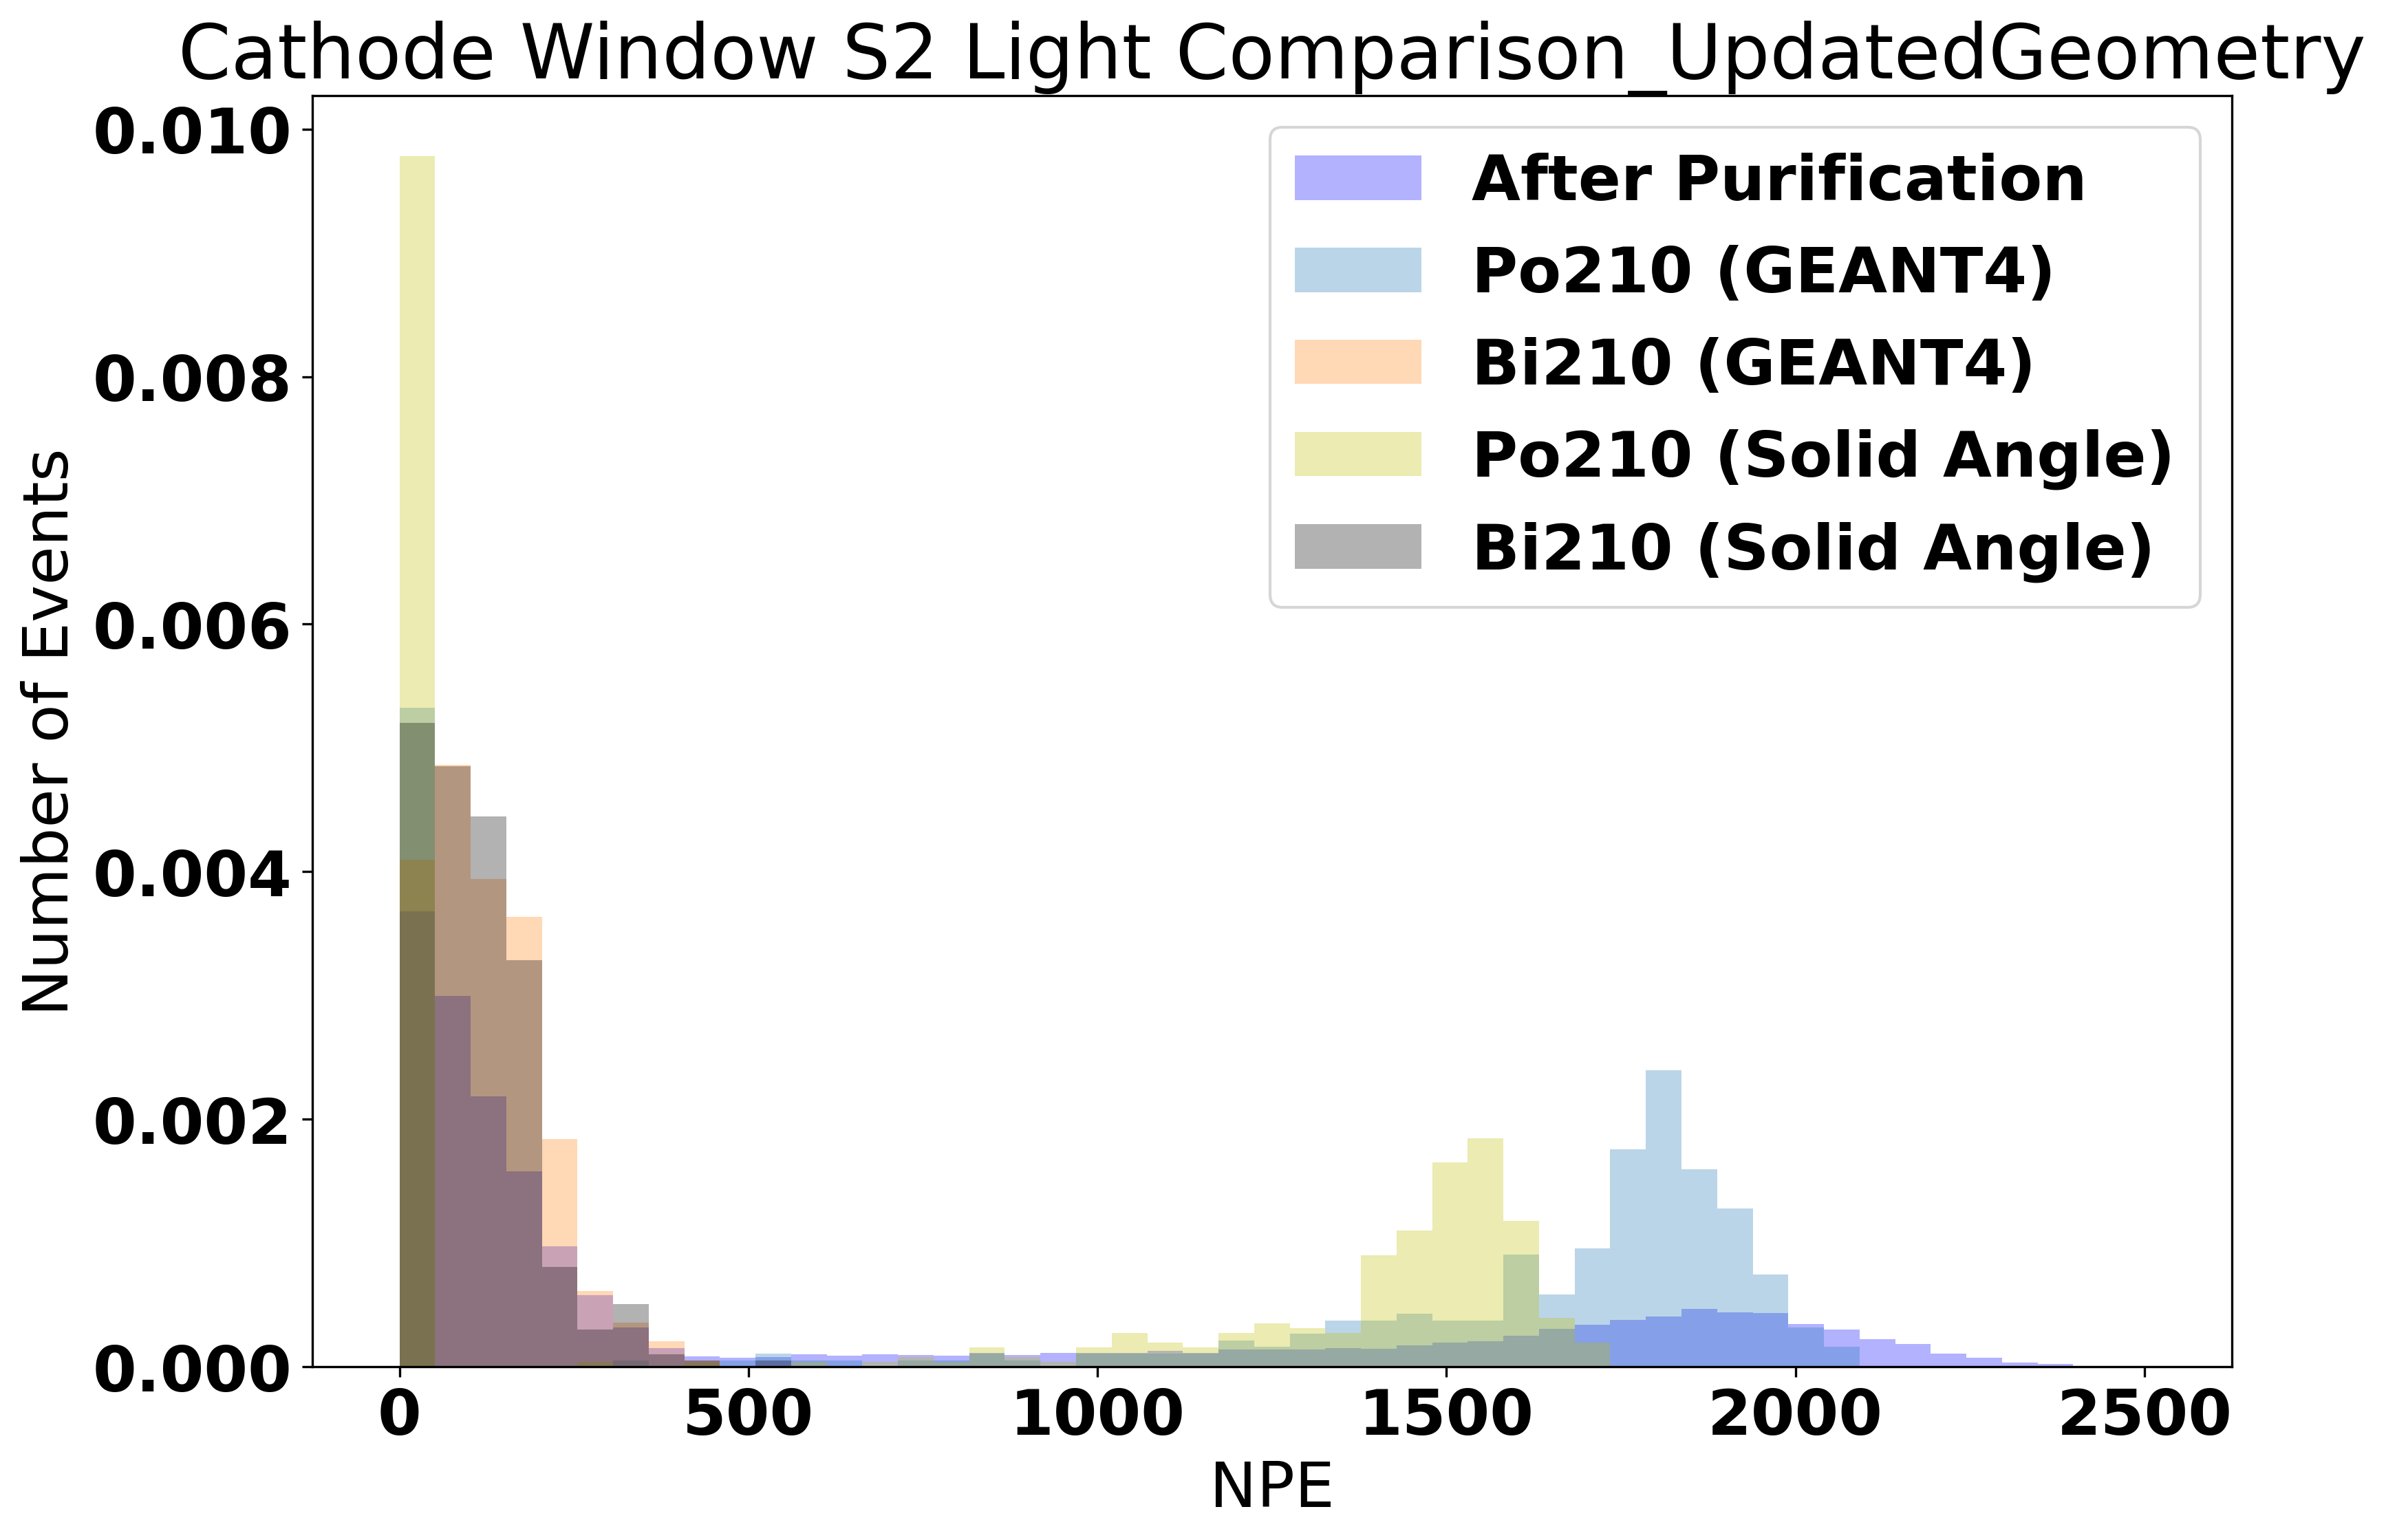

In [14]:
### Data Comp. Day2 PMT3 Comparison

binss=np.linspace(0,2500,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison_"+Tittle)
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(Result["CathodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="Po210 (GEANT4)",alpha=0.3)
plt.hist(Result["CathodeBetaPEs_G4"],bins=binss ,density=True,stacked=True,label="Bi210 (GEANT4)",alpha=0.3)
plt.hist(Result["SolidAngle_CathodeWindowAlphas"],bins=binss,density=True,stacked=True,label="Po210 (Solid Angle)",color="y",alpha=0.3)
plt.hist(Result["SolidAngle_CathodeWindowBetas"],bins=binss,density=True,stacked=True,label="Bi210 (Solid Angle)",color="k",alpha=0.3)
plt.legend()
#plt.savefig("/home/ilker/Desktop/CRAB_Pictures/PMT3_S2_Light_Yield_Comp.jpeg")

plt.show()



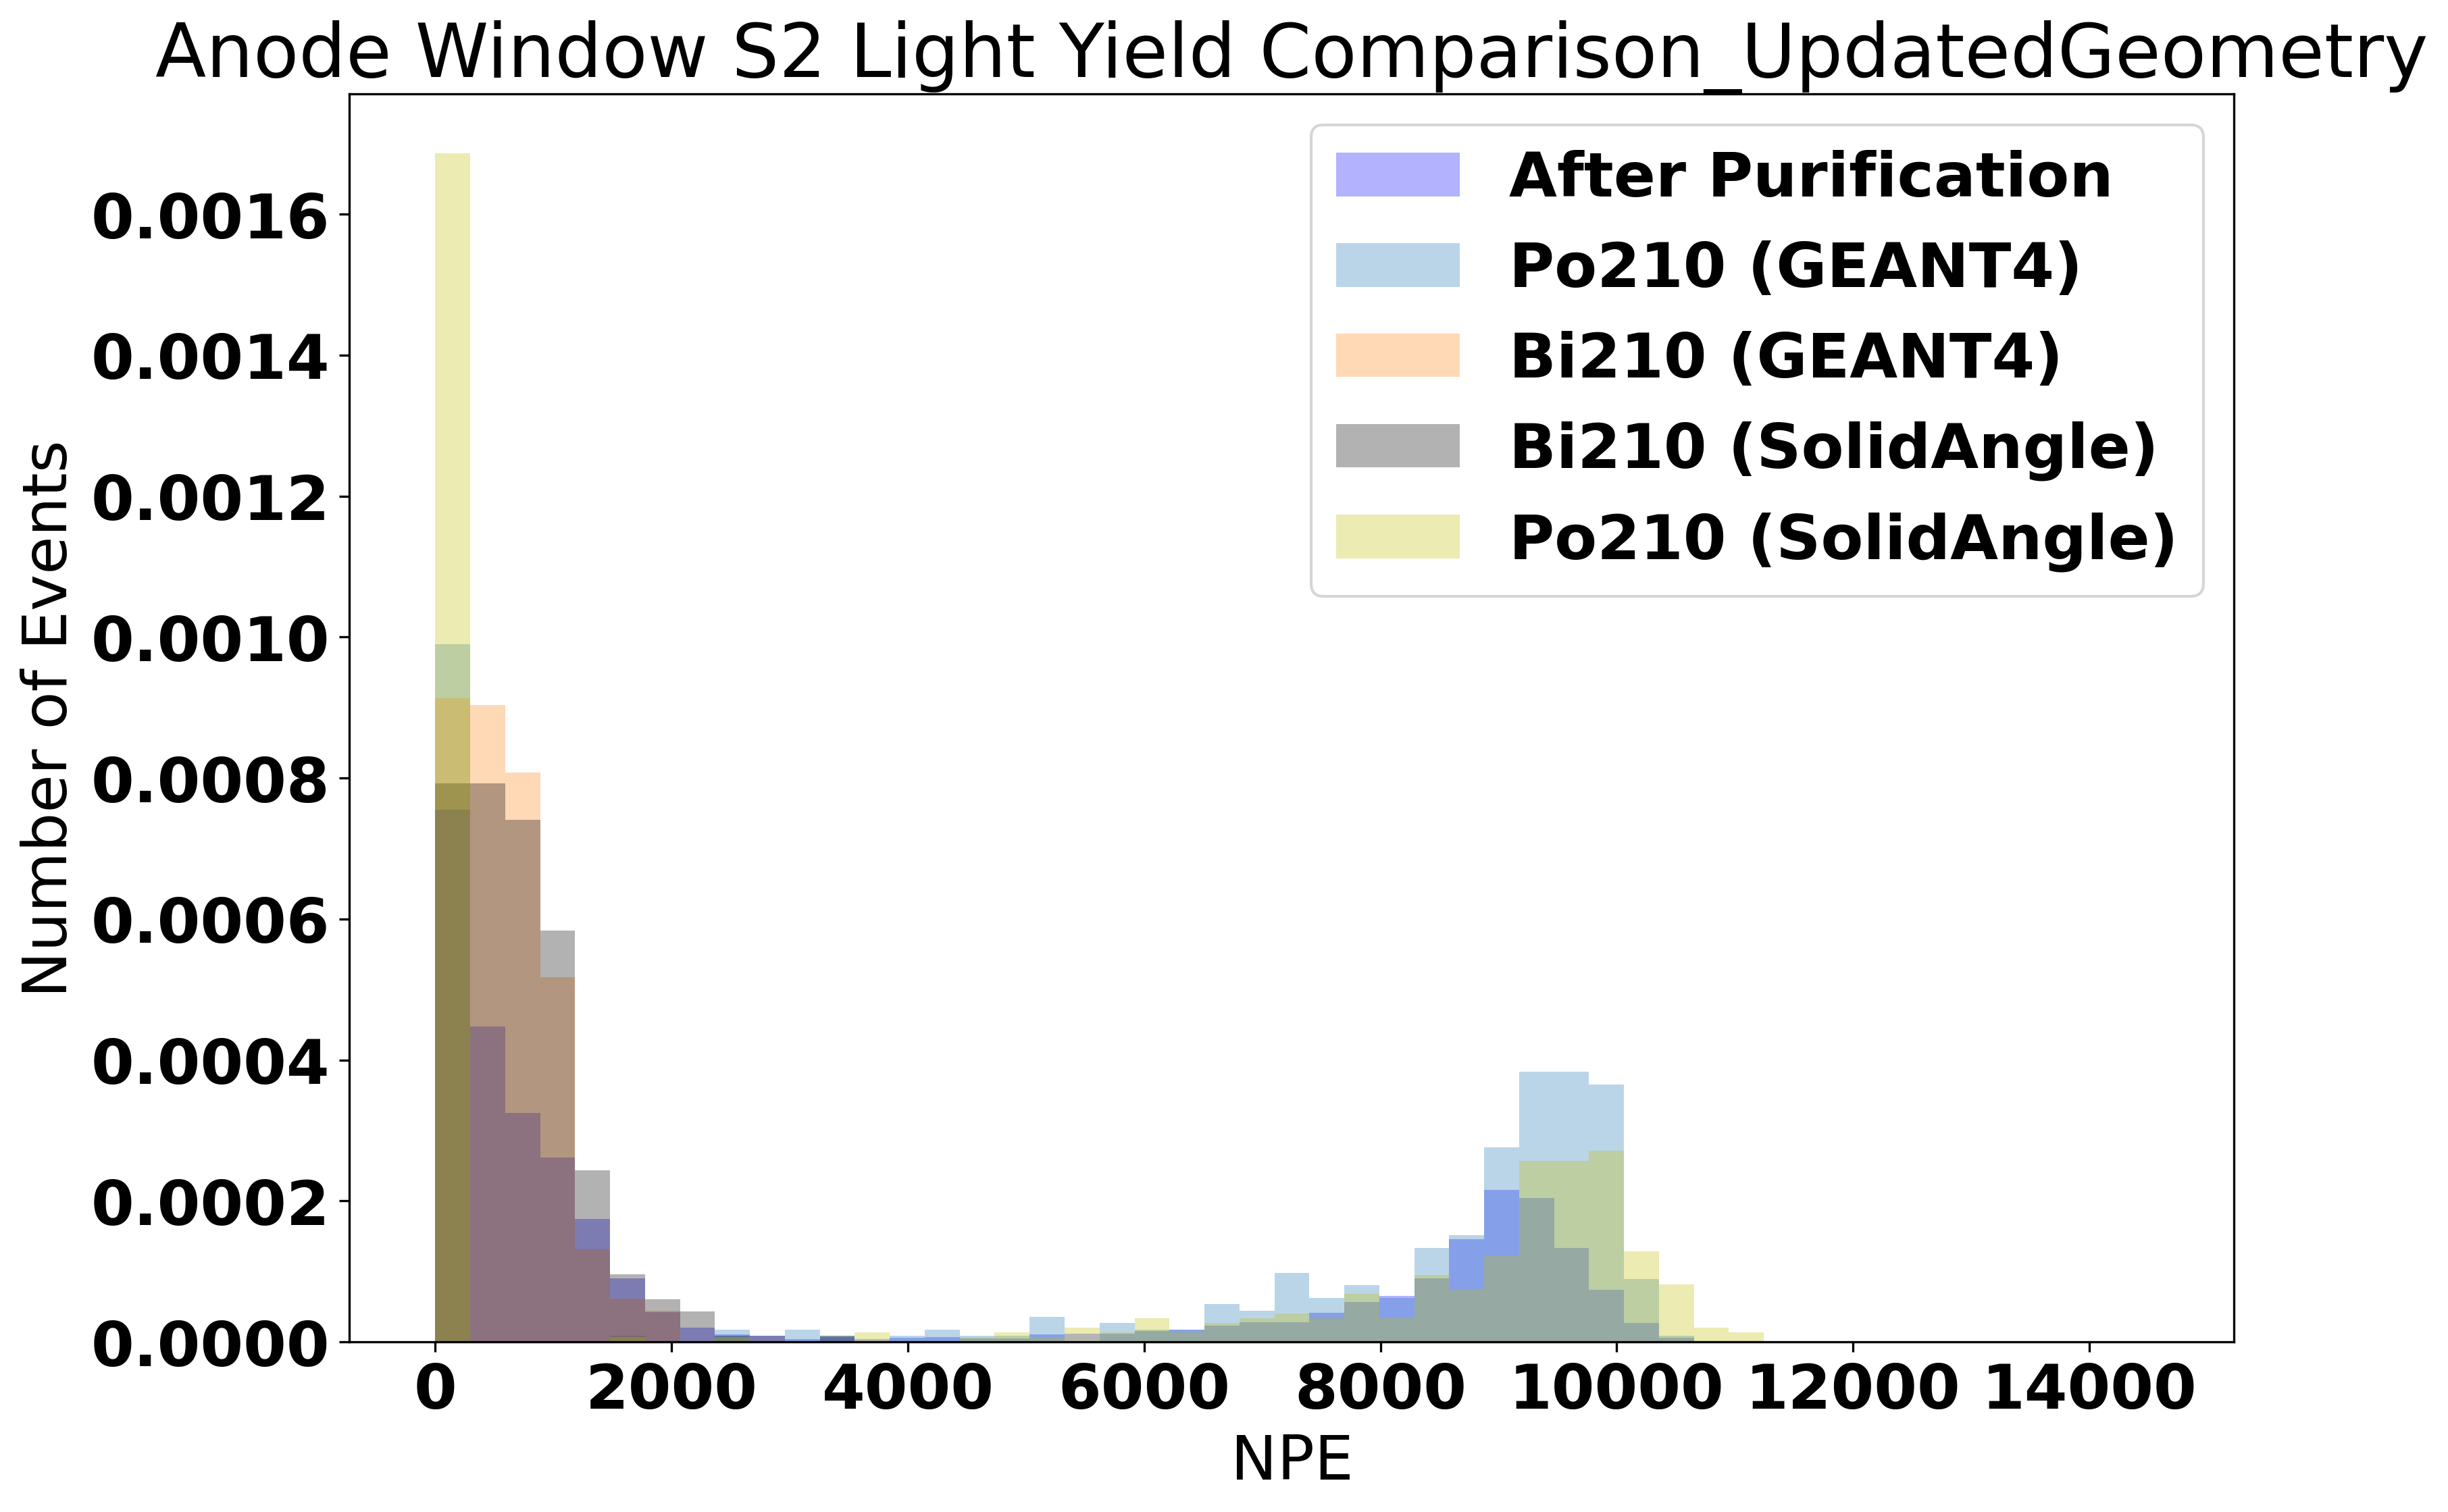

In [15]:
### Data Comp. Day2  PMT1 (Anode Window)
binss=np.linspace(0,14500,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Anode Window S2 Light Yield Comparison_"+Tittle)
plt.ylabel("Number of Events")
plt.xlabel("NPE")

plt.hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(Result["AnodeAlphaPEs_G4"],bins=binss ,density=True,stacked=True,label="Po210 (GEANT4)",alpha=0.3)
plt.hist(Result["AnodeBetaPEs_G4"],bins=binss ,density=True,stacked=True,label="Bi210 (GEANT4)",alpha=0.3)


plt.hist(Result["SolidAngle_AnodeWindowBetas"],bins=binss ,density=True,stacked=True,label="Bi210 (SolidAngle)",alpha=0.3,color="k")
plt.hist(Result["SolidAngle_AnodeWindowAlphas"],bins=binss ,density=True,stacked=True,label="Po210 (SolidAngle)",alpha=0.3,color="y")
plt.legend() 
#plt.savefig("/home/ilker/Desktop/CRAB_Pictures/PMT1_S2_Light_Yield_Comp.jpeg")

plt.show()

In [16]:
SimG4_Anode=Fit(Result["AnodeAlphaPEs_G4"],np.linspace(0,15000,60),3000,False)
SimSolidAngle_Anode=Fit(Result["SolidAngle_AnodeWindowAlphas"],np.linspace(0,15000,60),3000,False)
Data_Anode=Fit(Day2_PMT1_GainIL,np.linspace(0,15000,60),3000,False)

[  42.66001888 9455.88784146  481.48454529]
[  34.87938811 9604.2698726   551.79739234]
[1056.8684183  9096.9379052   596.27955564]


In [17]:
SimG4_Cathode=Fit(Result["CathodeAlphaPEs_G4"],np.linspace(0,3000,60),1200,False)
SimSolidAngle_Cathode=Fit(Result["SolidAngle_CathodeWindowAlphas"],np.linspace(0,3000,60),1200,False)

Data_Cathode=Fit(Day2_PMT3_GainIL,np.linspace(0,2600,60),1500,False)

[  36.183469   1809.88382233  117.87047065]
[  44.90122634 1524.09559964   90.35783109]
[ 412.55052973 1865.93281575  212.04182932]


In [18]:
### Simulation Light Yields
## Sim


ysim=np.array([SimG4_Cathode[1],SimG4_Anode[1]])
#ysimerr=[np.std(alpha_CathodeWindow_G4Filtered)/np.sqrt(len(alpha_CathodeWindow_G4Filtered)),np.std(alpha_AnodeWindow_G4Filtered)/np.sqrt(len(alpha_AnodeWindow_G4Filtered))]

## SolidAngle sim
ysolid=np.array([SimSolidAngle_Cathode[1],SimSolidAngle_Anode[1]])
#ysoliderr=[np.std(SolidAngle_AlphaCathodeWindow_G4Filtered)/np.sqrt(len(SolidAngle_AlphaCathodeWindow_G4Filtered)),np.std(SolidAngle_AlphaAnodeWindow_G4Filtered)/np.sqrt(len(SolidAngle_AlphaAnodeWindow_G4Filtered))]
yData=np.array([Data_Cathode[1],Data_Anode[1]])
yDataError=np.array([Data_Cathode[2],Data_Anode[2]])


In [19]:
#### Error Calculation
AnodeDataError={}
CathodeDataError={}

## Calculating Error on  betweem data,solid Angle and GEANT4
AnodeMeans=np.array([yData[1],ysim[1],ysolid[1]])
CathodeMeans=np.array([yData[0],ysim[0],ysolid[0]])

print(f"Anode Means {AnodeMeans}")
print(f"Cathode Means {CathodeMeans}")
AnodeDataError["Data"]=np.std(AnodeMeans)/np.sqrt(len(AnodeMeans))
CathodeDataError["Data"]=np.std(CathodeMeans)/np.sqrt(len(CathodeMeans))


## Calculating Error on between GEANT4 to DATA
AnodeMeans=np.array([yData[1],ysim[1]])
CathodeMeans=np.array([yData[0],ysim[0]])

AnodeDataError["GEANT4"]=np.std(AnodeMeans)/np.sqrt(len(AnodeMeans))
CathodeDataError["GEANT4"]=np.std(CathodeMeans)/np.sqrt(len(CathodeMeans))

## Calculating Error on between Solid Angle to DATA
AnodeMeans=np.array([yData[1],ysolid[1]])
CathodeMeans=np.array([yData[0],ysolid[0]])

AnodeDataError["SolidAngle"]=np.std(AnodeMeans)/np.sqrt(len(AnodeMeans))
CathodeDataError["SolidAngle"]=np.std(CathodeMeans)/np.sqrt(len(CathodeMeans))


### 
ydataerr=np.array([CathodeDataError["Data"],AnodeDataError["Data"]])
ysimerr=np.array([CathodeDataError["GEANT4"],AnodeDataError["GEANT4"]])
ysoliderr=np.array([CathodeDataError["SolidAngle"],AnodeDataError["SolidAngle"]])




Anode Means [9096.9379052  9455.88784146 9604.2698726 ]
Cathode Means [1865.93281575 1809.88382233 1524.09559964]


+----------------------+----------------------------+--------------------------+
| Comparison           |   Cathode Window Error (%) |   Anode Window Error (%) |
+======================+============================+==========================+
| GEANT4 and Geometric |                   15.7904  |                  1.5692  |
+----------------------+----------------------------+--------------------------+
| GEANT4 and Data      |                    3.00381 |                  3.94583 |
+----------------------+----------------------------+--------------------------+
| Geometric and Data   |                   18.3199  |                  5.57695 |
+----------------------+----------------------------+--------------------------+
+-----------+-----------------------+---------------+---------------------+---------------+
| Method    |   CathodeWindow (NPE) |   Error (NPE) |   AnodeWindow (NPE) |   Error (NPE) |
+===========+=======================+===============+=====================+============

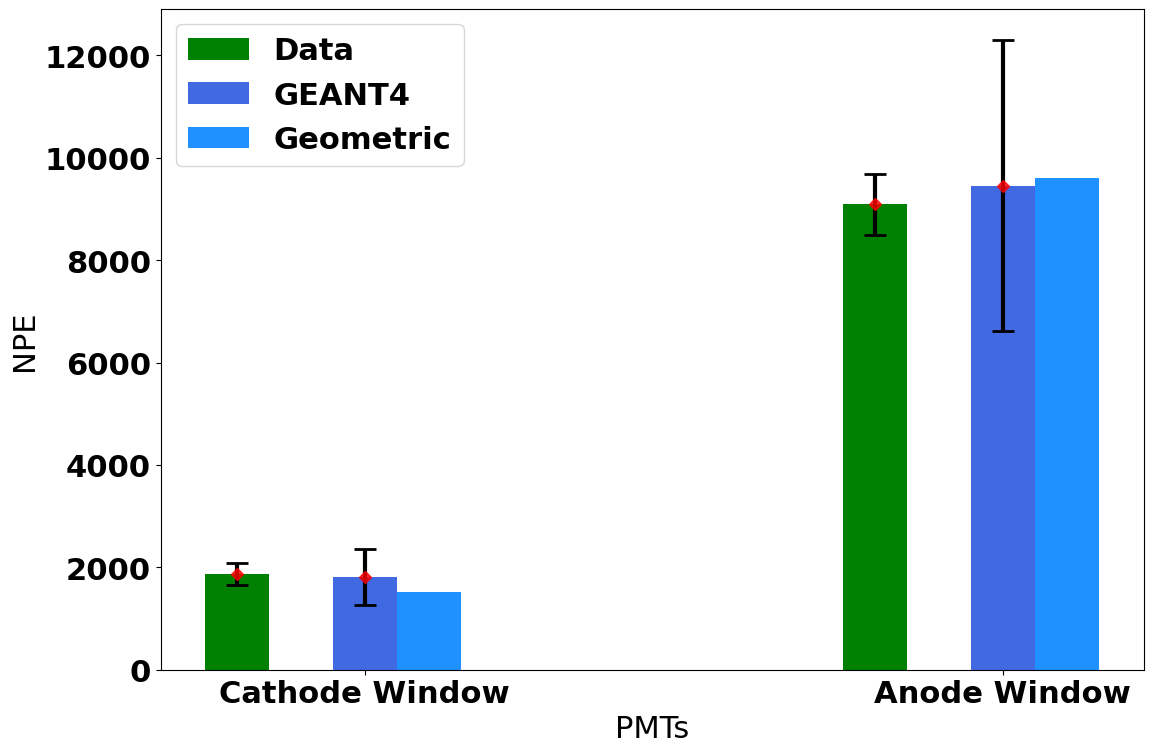

In [20]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True



yG4SolidPerror=(abs(100*(ysolid-ysim)/ysim))

yG4DataPerror=abs(100*(ysim-yData)/yData)

ySolidDataPerror=abs(100*(ysolid-yData)/yData)

## Error Percent
mydata = [
    ["GEANT4 and Geometric",yG4SolidPerror[0],yG4SolidPerror[1]],
    ["GEANT4 and Data", yG4DataPerror[0],yG4DataPerror[1]],
    ["Geometric and Data", ySolidDataPerror[0],ySolidDataPerror[1]]
]

# create header
head = ["Comparison", "Cathode Window Error (%)","Anode Window Error (%)"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


## 
# assign data
mydata = [
    ["Data",yData[0],Data_Cathode[2],yData[1],Data_Anode[2]],
    ["GEANT4", ysim[0],ysim[0]*0.3, ysim[1],ysim[1]*0.3],
    ["Geometric", ysolid[0],ysim[0]*0.3, ysolid[1],ysim[1]*0.3],
]
 
# create header
head = ["Method", "CathodeWindow (NPE)","Error (NPE)","AnodeWindow (NPE)","Error (NPE)"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


#print(f"\n Error in the Anode {AnodeDataError}")
#print(f" Error in the Cathode {CathodeDataError}")                       



ind = np.arange(2) # the x locations for the groups
width = 0.1 # the width of the bars
shift=-0.1
fig, ax = plt.subplots()

error_kw=dict(lw=3, capsize=8, capthick=2)

rects1 = ax.bar(ind - width+shift, yData, width, yerr=[Data_Cathode[2],Data_Anode[2]], label='Data',color="green",error_kw=error_kw)
ax.plot(ind - width+shift,yData,  marker="D", linestyle="", alpha=0.8, color="r",linewidth=35,markersize=6)

rects2 = ax.bar(ind + width+shift, ysim, width, yerr=(ysim*0.3), label='GEANT4',color="royalblue",error_kw=error_kw)
ax.plot(ind + width+shift,ysim,  marker="D", linestyle="", alpha=0.8, color="r",linewidth=35,markersize=6)

rects3 = ax.bar(ind + 2.01*width+shift, ysolid, width, label='Geometric',color="dodgerblue",error_kw=error_kw)
#ax.plot(ind + 2*width+shift,ysolid,  marker="D", linestyle="", alpha=0.8, color="r")

ax.set_ylabel('NPE')
ax.set_xlabel('PMTs')
#ax.set_title('PMTs')
ax.set_xticks(ind)
ax.set_xticklabels(('Cathode Window', 'Anode Window'))
ax.legend(loc="upper left")

plt.savefig("/home/ilker/Desktop/S2_Scatter_AfterPurifcation.png")
plt.show()



In [21]:
mydata = [
    ["Data",yData[0],ydataerr[0],yData[1],ydataerr[1]],
    ["GEANT4", ysim[0],ysimerr[0], ysim[1],ysimerr[1]],
    ["Solid Angle", ysolid[0],ysoliderr[0], ysolid[1],ysoliderr[1]]
]

In [22]:

MData=yData/5.3
MDataErr=(yDataError/5.3)

MG4=ysim/5.3
MG4Err=(ysim/5.3)*0.3
MSolid=(ysolid/5.3)
MSolidErr=(ysim/5.3)*0.3

 
# assign data
mydata = [
    ["Data", MData[0],MDataErr[0], MData[1],MDataErr[1]],
    ["GEANT4", MG4[0],MG4Err[0], MG4[1],MG4Err[1]],
    ["Solid Angle", MSolid[0],MSolidErr[0], MSolid[1],MSolidErr[1]]


]
 
# create header
head = ["Method", "CathodeWindow (NPE/MeV)","Error (NPE/MeV)","AnodeWindow (NPE/MeV)","Error (NPE/MeV)"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+-------------+---------------------------+-------------------+-------------------------+-------------------+
| Method      |   CathodeWindow (NPE/MeV) |   Error (NPE/MeV) |   AnodeWindow (NPE/MeV) |   Error (NPE/MeV) |
+=============+===========================+===================+=========================+===================+
| Data        |                   352.063 |           40.0079 |                 1716.4  |           112.506 |
+-------------+---------------------------+-------------------+-------------------------+-------------------+
| GEANT4      |                   341.488 |          102.446  |                 1784.13 |           535.239 |
+-------------+---------------------------+-------------------+-------------------------+-------------------+
| Solid Angle |                   287.565 |          102.446  |                 1812.13 |           535.239 |
+-------------+---------------------------+-------------------+-------------------------+-------------------+


In [23]:
font = {
        'weight' : 'bold',
        'size'   : 34}

matplotlib.rc('font', **font)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


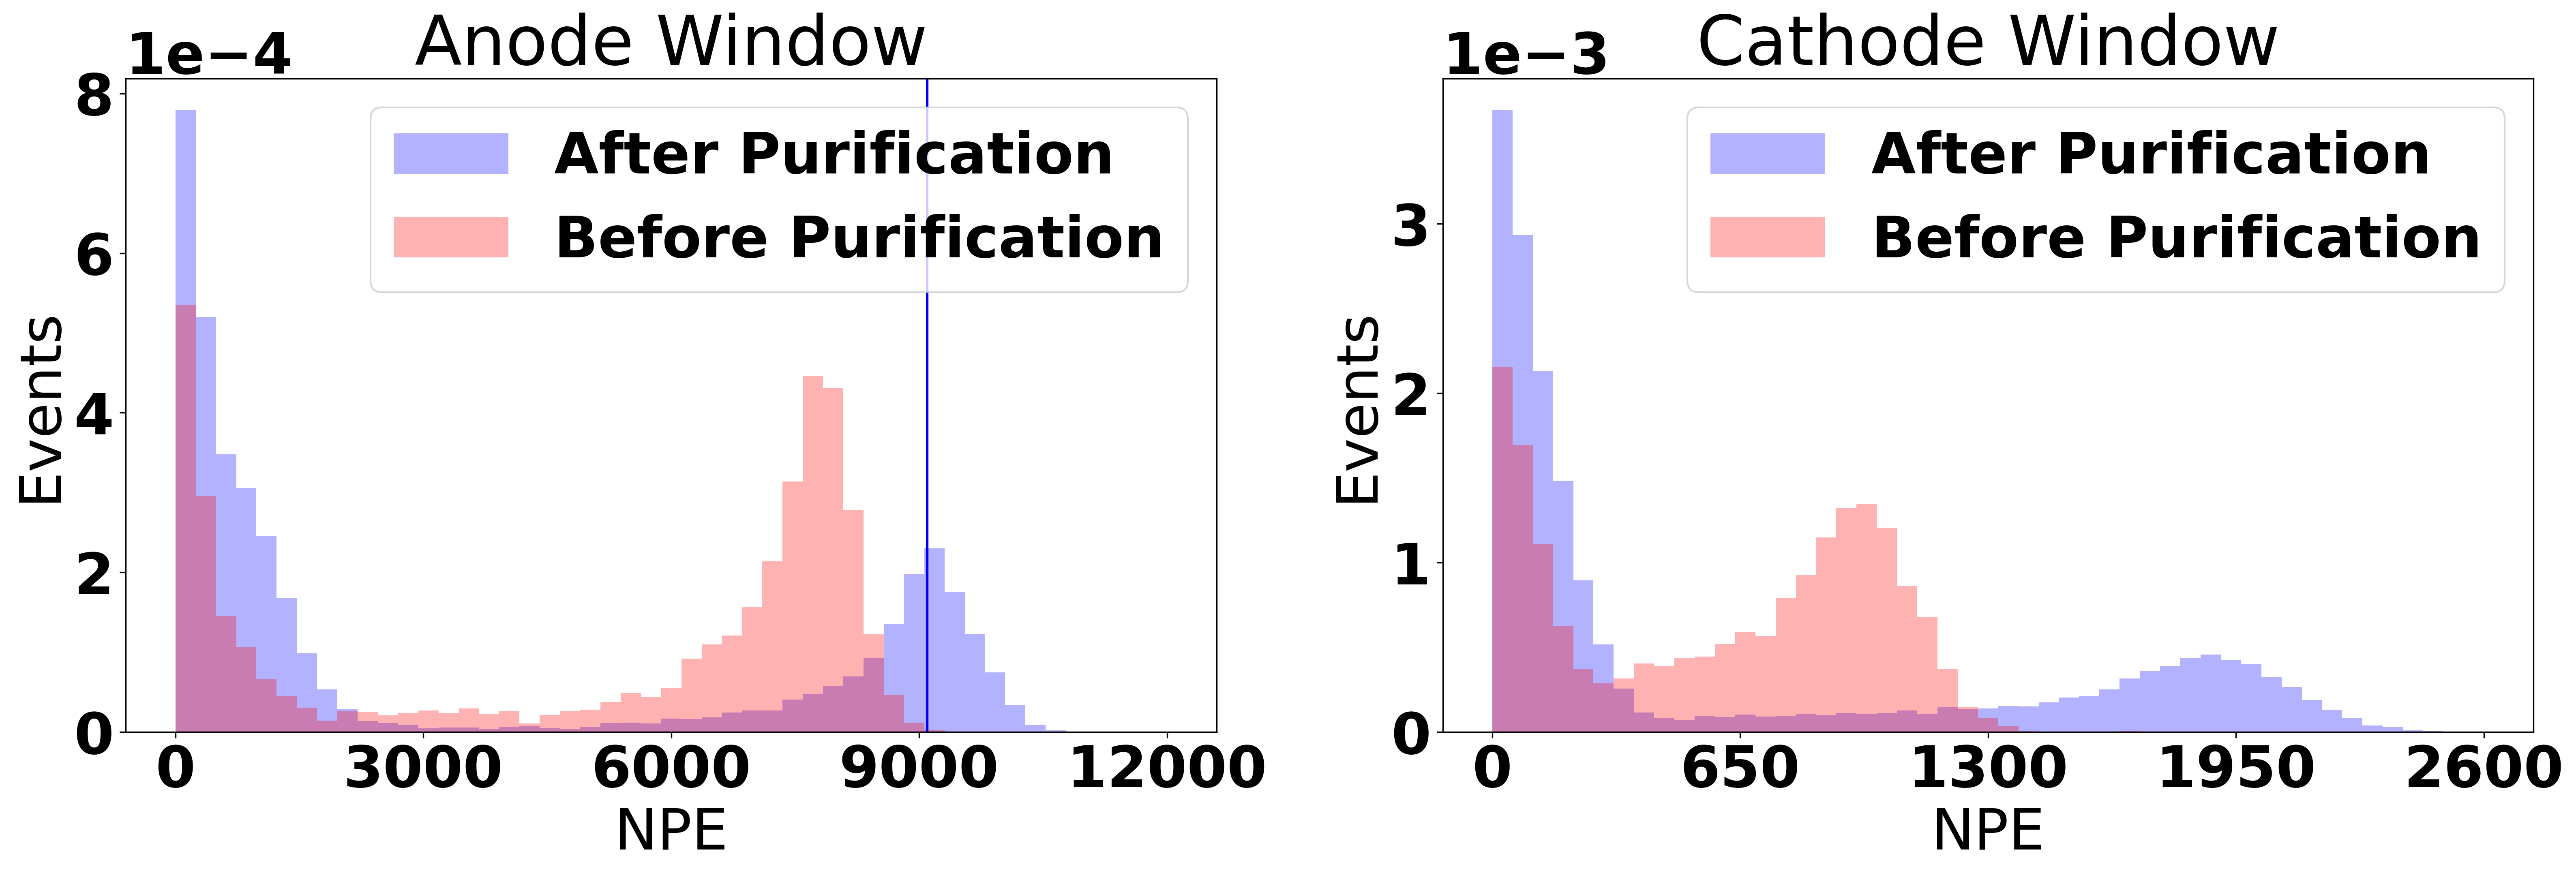

3463.1892407728296


In [24]:
figure, axis = plt.subplots(1, 2,figsize=(22,8),dpi=300)
binss=np.linspace(0,12000,50)
axis[0].set_title("Anode Window")
axis[0].hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
axis[0].hist(Day1_PMT1_GainIL,bins=binss,density=True,stacked=True,label="Before Purification",color="r",alpha=0.3)
axis[0].set_xlabel("NPE")
axis[0].set_ylabel("Events")
axis[0].legend()
axis[0].ticklabel_format(style = 'sci',axis='y',  scilimits=(0,0))
axis[0].set_xticks(np.linspace(0, 12000, 5))
axis[0].axvline(x = 9096.94, color = 'b', label = 'axvline - full height')

binss=np.linspace(0,2600,50)
axis[1].set_title("Cathode Window")
axis[1].hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
axis[1].hist(Day1_PMT3_GainIL,bins=binss,density=True,stacked=True,label="Before Purification",color="r",alpha=0.3)
axis[1].set_xlabel("NPE")
axis[1].set_ylabel("Events")
axis[1].legend()
axis[1].ticklabel_format(style = 'sci',axis='y', scilimits=(0,0))
plt.savefig("/home/ilker/Desktop/S2LightYields.png",bbox_inches='tight')
axis[1].set_xticks(np.linspace(0, 2600, 5))
plt.tight_layout()
plt.show()
print(max(Day2_PMT3_GainIL))